In [1]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install statsmodels
!pip install matplotlib
!pip install feature-engine
!pip install scikit-learn
!pip install xgboost




In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import feature_engine
import sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer




## Cluster ---- KMeans
#### It looks to group the data by similarity
#### Unsupervised learning, there is no target feature and the algorithm is left alone searching for patterns in the data


#### Create Cluster pipeline ---- Data cleaning, data scaling, feature engineering, PCA and Cluster Model (KMeans)
#### Fit Cluster pipeline
#### Understand Cluseter profile ------ We use a classifier where the target is the Clusters predictor
#### Cluster Analysis

In [29]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.iloc[:10,4] = np.NaN
print(df.shape)
df.head()

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,NaN,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,NaN,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,NaN,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,NaN,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,NaN,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [30]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ('MeanMedianImputer', MeanMedianImputer(imputation_method='median',
                                                variables=['mean smoothness'])),
        ("scaler", StandardScaler()),

        ('PCA', PCA(n_components=50, random_state=0)),

        ('model', KMeans(n_clusters=50, random_state=0)),
        
    ])
    return pipeline_base

PipelineCluster()    

Pipeline(steps=[('MeanMedianImputer',
                 MeanMedianImputer(variables=['mean smoothness'])),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=50, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

### PCA Principal Components Analysis
#### Finds out what features are more relevant and explain the variance of the data so we can reduce variables and optimize the model

In [31]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)
print(df_pca.shape, '\n', type(df_pca))

(569, 30) 
 <class 'numpy.ndarray'>


In [32]:
n_components = 7  # Set the number of components as all columns in the data

# Set up PCA object and fit it to the data
pca = PCA(n_components=n_components).fit(df_pca)

# Array with transformed PCA
X_PCA = pca.transform(df_pca)

# The PCA object has explained_variance_ratio_ attribute, which tells
# how much information (variance) each component has.
# We store that information in a DataFrame relating each component to its variance explanation.
ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data=np.round(100 * pca.explained_variance_ratio_, 2),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)']
)

# Prints how much of the dataset these components explain (naturally in this case will be 100%)
PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()
print(f"* The {n_components} components explain {round(PercentageOfDataExplained, 2)}% of the data.\n")
print(dfExplVarRatio)

* The 7 components explain 90.89% of the data.

             Explained Variance Ratio (%)
Component 0                         44.21
Component 1                         18.86
Component 2                          9.36
Component 3                          6.61
Component 4                          5.48
Component 5                          4.09
Component 6                          2.28


#### Now that we know the number of columns 30 and the PCA n_components to achieve more than 90% is 7 we rewrite the pipeline

In [33]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ('MeanMedianImputer', MeanMedianImputer(imputation_method='median',
                                                variables=['mean smoothness'])),
        ("scaler", StandardScaler()),

        ('PCA', PCA(n_components=7, random_state=0)),

        ('model', KMeans(n_clusters=30, random_state=0)),
        
    ])
    return pipeline_base

PipelineCluster()    

Pipeline(steps=[('MeanMedianImputer',
                 MeanMedianImputer(variables=['mean smoothness'])),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model', KMeans(n_clusters=30, random_state=0))])

### Elbow Method & Silhouette Score (-1 data point might be in wrong cluster might be wrong, 0 might be overlapping, 1 means enough distance)
#### Find the most suitable number of clusters --- n_cluster and update the pipeline
#### Combine both techniques to find the optimal value for number of clusters

In [34]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)
print(df_analysis.shape, '\n', type(df_analysis))

(569, 7) 
 <class 'numpy.ndarray'>


In [9]:
!pip install yellowbrick


/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

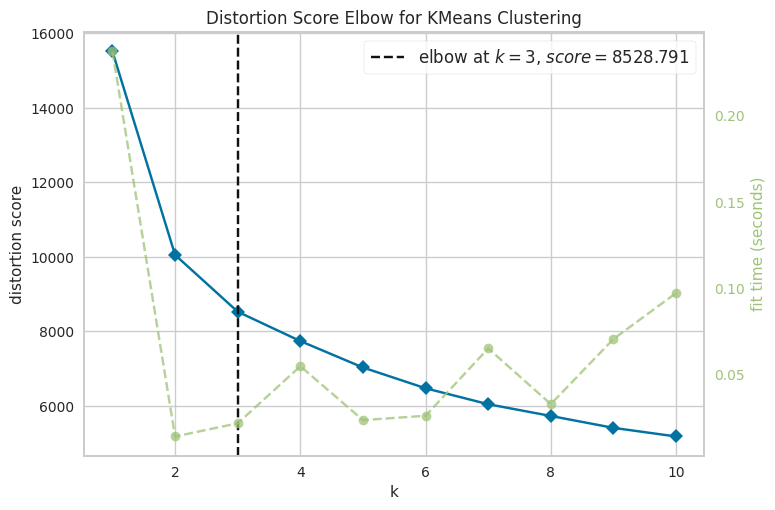

<function matplotlib.pyplot.show(close=None, block=None)>

In [10]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis)
visualizer.show()
plt.show

=== Average Silhouette Score for Different Numbers of Clusters ===


/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

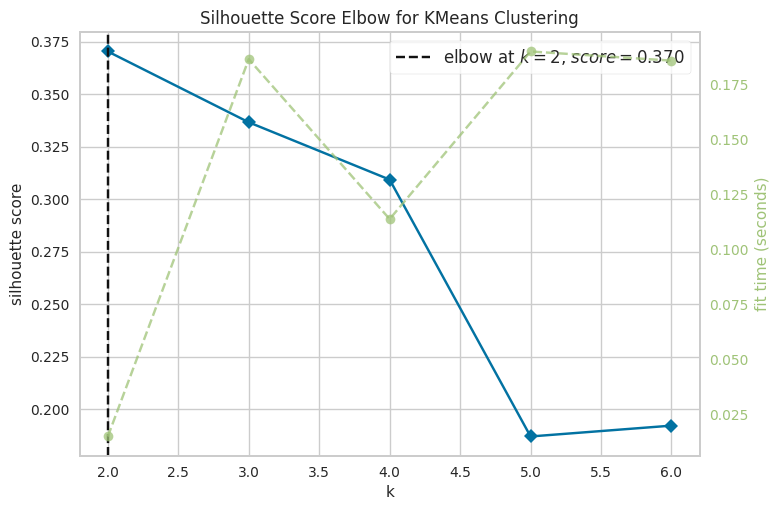

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following famil



=== Silhouette Plot for 2 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

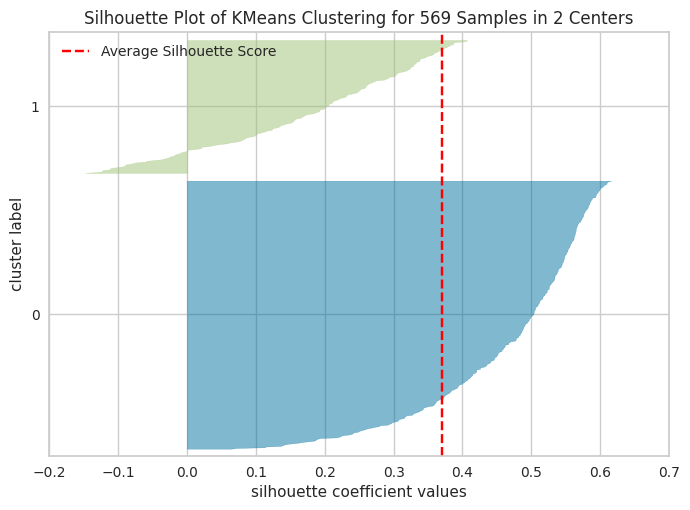

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following famil



=== Silhouette Plot for 3 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

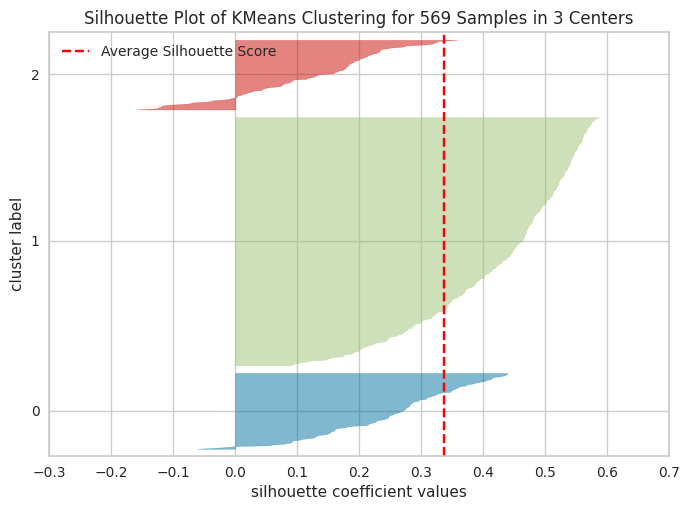

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following famil



=== Silhouette Plot for 4 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

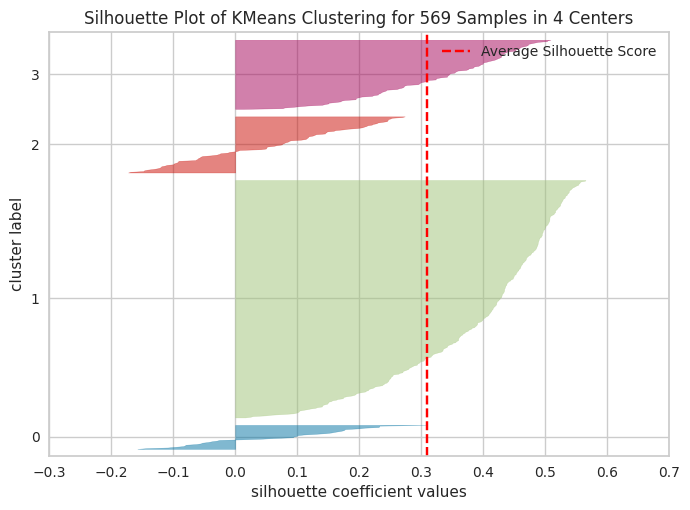

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette Plot for 5 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

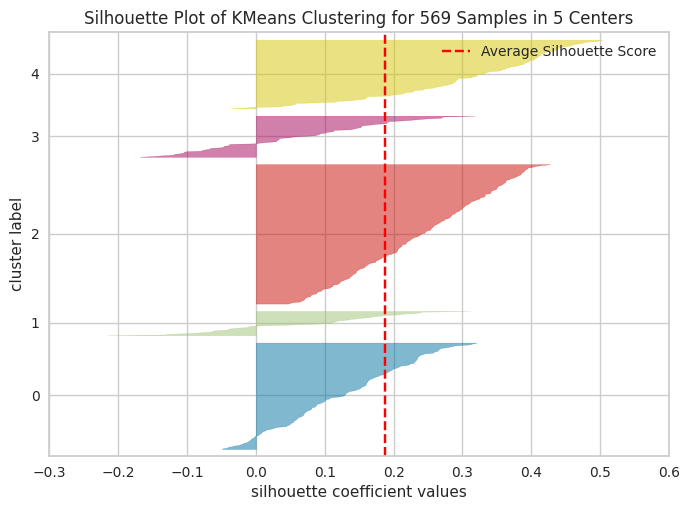

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following famil



=== Silhouette Plot for 6 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

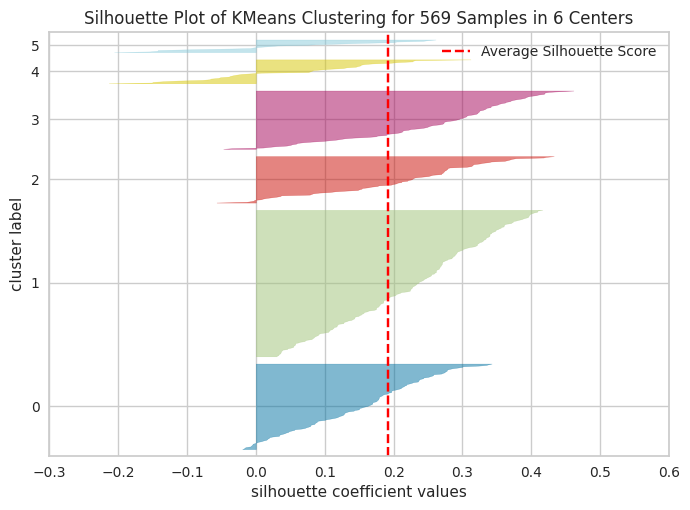

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following famil



=== Silhouette Plot for 7 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

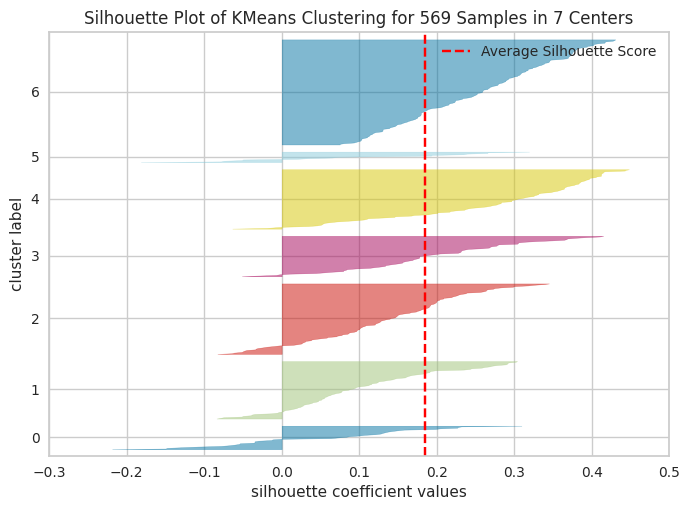

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette Plot for 8 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

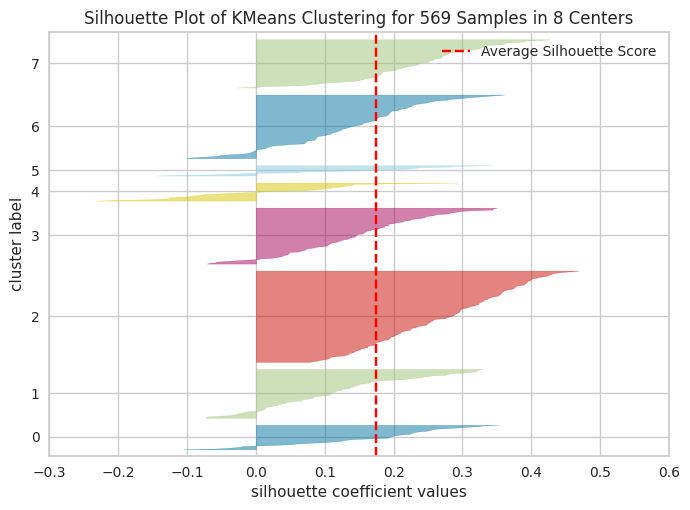

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif




=== Silhouette Plot for 9 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

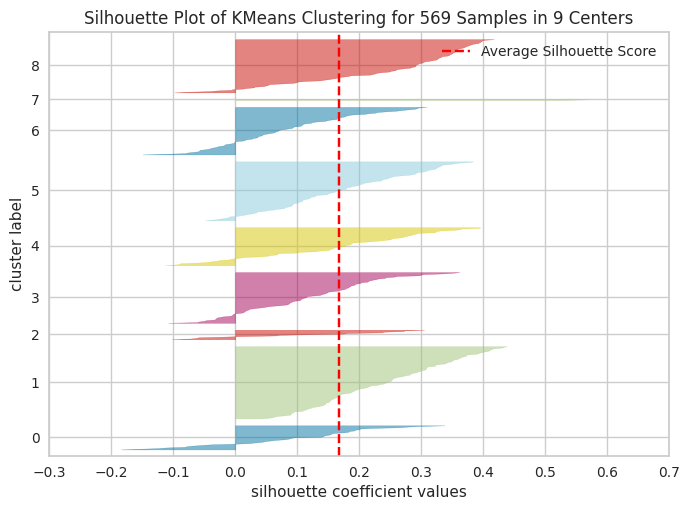

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)




=== Silhouette Plot for 10 Clusters ===


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

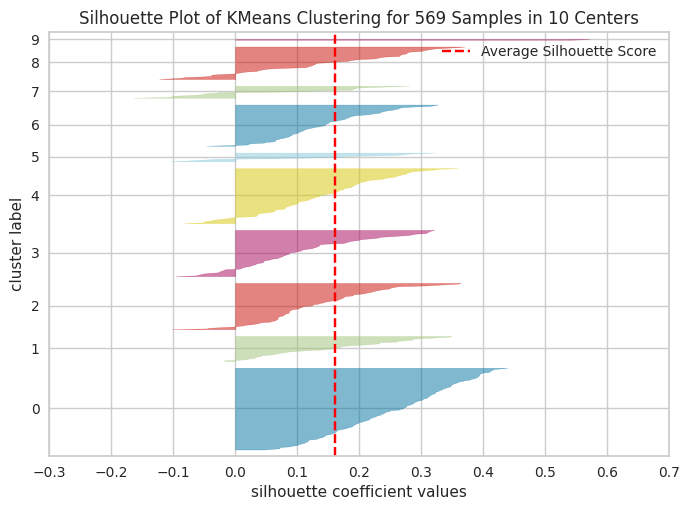

In [11]:
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.cluster import KMeans

# Load or define your dataset (assuming 'df_analysis' is your data)

print("=== Average Silhouette Score for Different Numbers of Clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(2, 7), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

print("\n")

for n_clusters in np.arange(start=2, stop=11):
    print(f"=== Silhouette Plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(
        estimator=KMeans(n_clusters=n_clusters, random_state=0),
        colors='yellowbrick'
    )
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()

    print("\n")

In [35]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ('MeanMedianImputer', MeanMedianImputer(imputation_method='median',
                                                variables=['mean smoothness'])),
        ("scaler", StandardScaler()),

        ('PCA', PCA(n_components=7, random_state=0)),

        ('model', KMeans(n_clusters=3, random_state=0)),
        
    ])
    return pipeline_base

PipelineCluster()    

Pipeline(steps=[('MeanMedianImputer',
                 MeanMedianImputer(variables=['mean smoothness'])),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

In [36]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df.iloc[:10,4] = np.NaN
print(df.shape)
df.head()

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,NaN,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,NaN,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,NaN,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,NaN,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,NaN,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [37]:
X = df.copy()
print (X.shape)
X.head(3)

(569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,NaN,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,NaN,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,NaN,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [38]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

/home/gitpod/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Pipeline(steps=[('MeanMedianImputer',
                 MeanMedianImputer(variables=['mean smoothness'])),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

In [39]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Clusters
0,17.99,10.38,122.8,1001.0,NaN,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,NaN,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,NaN,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [40]:
cluster_frequencies = X['Clusters'].value_counts(normalize=True).to_frame().round(2)
print(f"* Cluster Frequencies:\n{cluster_frequencies}\n")


* Cluster Frequencies:
          proportion
Clusters            
1               0.63
0               0.19
2               0.18



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

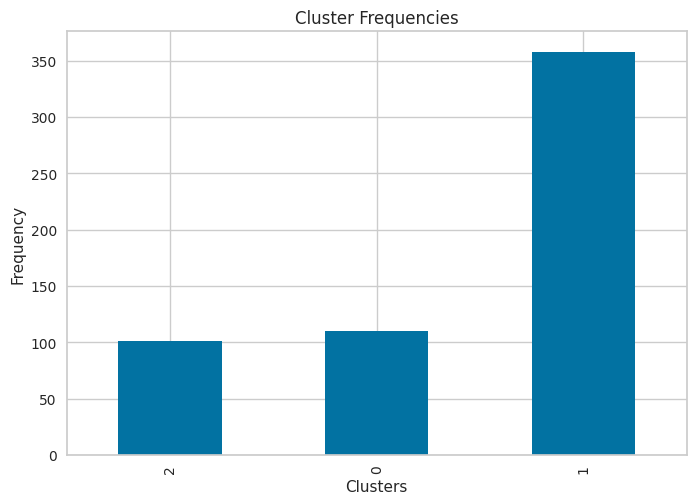

In [41]:
cluster_counts = X['Clusters'].value_counts().sort_values()
cluster_counts.plot(kind='bar')
plt.title("Cluster Frequencies")
plt.xlabel("Clusters")
plt.ylabel("Frequency")
plt.show()


### Fit a Classifier where the Cluster is Target
#### Here we interpret the clusters following the regular steps for regression and classification
#### 1 - Split the data into training and testing
#### 2 - Create the pipeline with classification task
#### 3 - fit the classifier for training data
#### 4 - Evaluate pipeline performance
#### 5 - Asses feature importance

In [43]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Clusters
0,17.99,10.38,122.8,1001.0,NaN,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,NaN,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,NaN,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df_clf.drop(['Clusters'], axis=1),
                                        df_clf['Clusters'],
                                        test_size=0.2,
                                        random_state=(101))
print("* Train set:", X_train.shape, y_train.shape,"\n* Test set:", X_test.shape, y_test.shape)         



* Train set: (455, 30) (455,) 
* Test set: (114, 30) (114,)


In [46]:
# ML Algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [47]:
def PipelineC1f2ExplainClusters():
    pipeline_base = Pipeline([
        ('MeanMedianImputer', MeanMedianImputer(imputation_method='median', variables=['mean smoothness'])),
        ('scaler', StandardScaler()),
        ('feat_selection', SelectFromModel(GradientBoostingClassifier(random_state=0))),
        ('model', GradientBoostingClassifier(random_state=0))
    ])
    return pipeline_base

PipelineC1f2ExplainClusters()

Pipeline(steps=[('MeanMedianImputer',
                 MeanMedianImputer(variables=['mean smoothness'])),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

In [48]:
pipeline_clf_cluster = PipelineC1f2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('MeanMedianImputer',
                 MeanMedianImputer(variables=['mean smoothness'])),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00       285
           2       1.00      1.00      1.00        83

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455



In [53]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.95      0.99      0.97        73
           2       1.00      0.72      0.84        18

    accuracy                           0.94       114
   macro avg       0.94      0.89      0.91       114
weighted avg       0.94      0.94      0.94       114



### PCA (Principal Component Analysis)
#### Intends to explain which variables explain the most variance in your data
#### Also referred as "Dimensionality reduction"

In [12]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = pd.Series(data.target)
df = df.sample(frac=0.6, random_state=101)
df.iloc[:10,4] = np.NaN
print(X.shape)
df.head()

NameError: name 'X' is not defined

In [ ]:
df_target = df[['target']]
X = df.drop(['target'], axis=1)
print(X.shape)
X.head(3)

(341, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
107,12.36,18.54,79.01,466.7,NaN,0.06815,0.02643,0.01921,0.1602,0.06066,...,13.29,27.49,85.56,544.1,0.1184,0.1963,0.1937,0.08442,0.2983,0.07185
437,14.04,15.98,89.78,611.2,NaN,0.05895,0.03534,0.02944,0.1714,0.05898,...,15.66,21.58,101.20,750.0,0.1195,0.1252,0.1117,0.07453,0.2725,0.07234
195,12.91,16.33,82.53,516.4,NaN,0.05366,0.03873,0.02377,0.1829,0.05667,...,13.88,22.00,90.81,600.6,0.1097,0.1506,0.1764,0.08235,0.3024,0.06949


In [ ]:
def PipelineDataCleanFeatEng():
    pipeline_base = Pipeline([
        ('MeanMedianImputer', MeanMedianImputer(imputation_method='median')),

        ("feature_scaling", StandardScaler()),
        
    ])
    return pipeline_base

PipelineDataCleanFeatEng()    

Pipeline(steps=[('MeanMedianImputer', MeanMedianImputer()),
                ('feature_scaling', StandardScaler())])

In [ ]:
pipeline_pca = PipelineDataCleanFeatEng()
df_pca = pipeline_pca.fit_transform(X)
print(df_pca.shape, '\n', type(df_pca))

(341, 30) 
 <class 'numpy.ndarray'>


In [ ]:
df_pca

array([[-0.56738473, -0.16536585, -0.59933184, ..., -0.50820136,
         0.1792575 , -0.63049085],
       [-0.07141397, -0.77390549, -0.13893309, ..., -0.66545513,
        -0.27508597, -0.60317217],
       [-0.40501335, -0.69070671, -0.44885797, ..., -0.54111494,
         0.25145937, -0.76206648],
       ...,
       [ 2.35825232,  0.10324735,  2.55506217, ...,  2.77647856,
         2.06707222,  0.82130135],
       [-0.88031867, -0.24856463, -0.81649299, ...,  0.08615112,
         0.75158939,  2.59478483],
       [ 0.34779941, -1.74614265,  0.40482476, ...,  1.0544782 ,
         0.58957544,  0.99469128]])

In [ ]:
n_components = 30  # Set the number of components as all columns in the data

# Set up PCA object and fit it to the data
pca = PCA(n_components=n_components).fit(df_pca)

# Array with transformed PCA
X_PCA = pca.transform(df_pca)

# The PCA object has explained_variance_ratio_ attribute, which tells
# how much information (variance) each component has.
# We store that information in a DataFrame relating each component to its variance explanation.
ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data=np.round(100 * pca.explained_variance_ratio_, 2),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)']
)

# Prints how much of the dataset these components explain (naturally in this case will be 100%)
PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()
print(f"* The {n_components} components explain {round(PercentageOfDataExplained, 2)}% of the data.\n")
print(dfExplVarRatio)

* The 30 components explain 100.0% of the data.

              Explained Variance Ratio (%)
Component 0                          43.68
Component 1                          18.48
Component 2                          10.31
Component 3                           6.72
Component 4                           5.88
Component 5                           3.86
Component 6                           2.44
Component 7                           1.63
Component 8                           1.31
Component 9                           1.05
Component 10                          0.96
Component 11                          0.84
Component 12                          0.73
Component 13                          0.42
Component 14                          0.34
Component 15                          0.26
Component 16                          0.23
Component 17                          0.22
Component 18                          0.14
Component 19                          0.11
Component 20                          0.09
Compo

In [ ]:
n_components = 7  # Set the number of components as all columns in the data

# Set up PCA object and fit it to the data
pca = PCA(n_components=n_components).fit(df_pca)

# Array with transformed PCA
X_PCA = pca.transform(df_pca)

# The PCA object has explained_variance_ratio_ attribute, which tells
# how much information (variance) each component has.
# We store that information in a DataFrame relating each component to its variance explanation.
ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data=np.round(100 * pca.explained_variance_ratio_, 2),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)']
)

# Prints how much of the dataset these components explain (naturally in this case will be 100%)
PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()
print(f"* The {n_components} components explain {round(PercentageOfDataExplained, 2)}% of the data.\n")
print(dfExplVarRatio)

* The 7 components explain 91.37% of the data.

             Explained Variance Ratio (%)
Component 0                         43.68
Component 1                         18.48
Component 2                         10.31
Component 3                          6.72
Component 4                          5.88
Component 5                          3.86
Component 6                          2.44


In [ ]:
X_PCA

array([[-3.19632096, -0.7882415 , -1.54280305, ...,  0.31482589,
         0.25021347,  0.14958942],
       [-2.15148256, -0.97430915,  0.45730527, ..., -0.43744131,
        -0.18081375, -0.0783528 ],
       [-2.81567468, -0.67506773, -0.47638179, ..., -0.0187848 ,
         0.84195774, -0.40380846],
       ...,
       [13.25075397,  0.68891084,  0.36451787, ..., -1.0003148 ,
         0.78704341,  0.10109186],
       [ 1.2548625 ,  4.93892792, -1.0380955 , ...,  1.71789741,
         1.0133776 ,  1.24697795],
       [ 2.83513614,  1.09372726, -2.33467669, ..., -0.15095285,
        -0.77420664, -0.15741655]])

<function matplotlib.pyplot.show(close=None, block=None)>

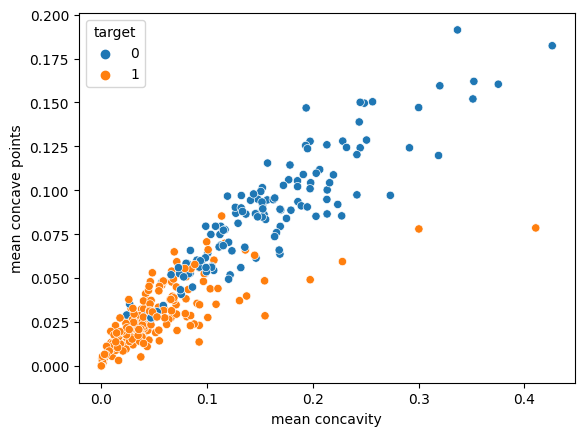

In [ ]:
var1, var2 = 'mean concavity', 'mean concave points'
sns.scatterplot(x=X[var1], y=X[var2], hue=df_target['target'])
plt.xlabel(var1)
plt.ylabel(var2)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

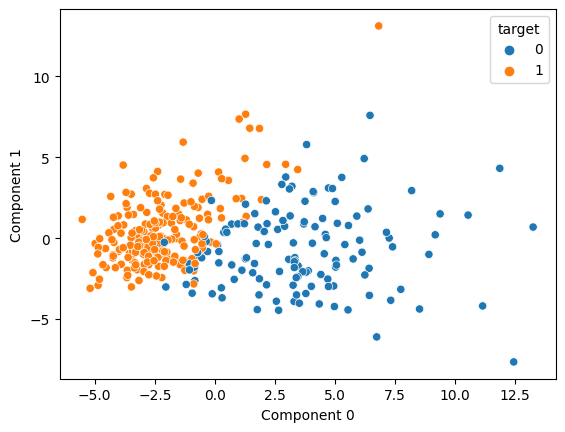

In [ ]:
sns.scatterplot(x=X_PCA[:,0], y=X_PCA[:,1], hue=df_target['target'])
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.show

In [ ]:
principal_components = pca.components_

components_df = pd.DataFrame(principal_components, columns=df.columns)


ValueError: Shape of passed values is (7, 30), indices imply (7, 31)